# Lung Tumor Segmentation 4:
## UNet Training
#### Notebook Link: https://www.kaggle.com/code/aryankashyapnaveen/lung-tumor-segmentation-unet-training?rvi=1

In [ ]:
%matplotlib notebook

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
%matplotlib inline
from glob import glob

In [4]:
!pip install celluloid
from celluloid import Camera

In [5]:
path = Path("/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/0")  # Select a subject. Check the folder if it exists

In [6]:
list(path.glob("*"))

[PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/0/masks'),
 PosixPath('/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/0/data')]

In [7]:
# Choose a file and load slice + mask
file = "3.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

In [8]:
from IPython.display import HTML

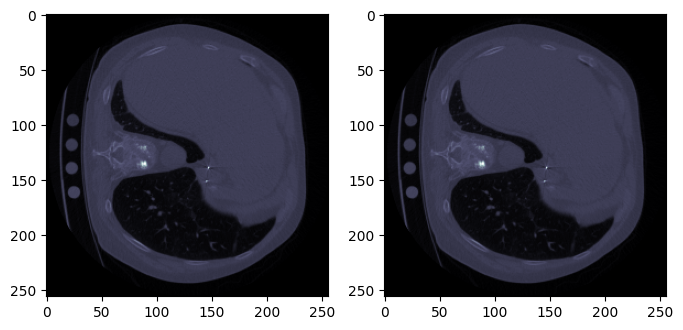

In [9]:
fig, axis = plt.subplots(1, 2, figsize=(8, 8))
axis[0].imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
axis[1].imshow(slice, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")

In [10]:
print(slice.min(), slice.max())

-0.33344187561055033 0.9192445457505698


In [11]:
!pip install pytorch_lightning

In [12]:
!pip uninstall imgaug --yes
!pip install imgaug

Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 5.2 MB/s eta 0:00:00


In [13]:
from pathlib import Path
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [14]:
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

class LungDataset(torch.utils.data.Dataset):
    """
    Dataset class for lung tumor segmentation.
    
    Args:
        root (str): The root path of the dataset.
        augment_params (dict): Parameters for data augmentation.
    """
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
    
    @staticmethod
    def extract_files(root):
        """
        Extract the paths to all slices given the root path (ends with train or val)
        
        Args:
            root (str): The root path of the dataset.
        
        Returns:
            list: A list of file paths to all slices.
        """
        files = []
        for subject in root.glob("*"):   # Iterate over the subjects
            slice_path = subject/"data"  # Get the slices for current subject
            for slice in slice_path.glob("*"):
                files.append(slice)
        return files
    
    
    @staticmethod
    def change_img_to_label_path(path):
        """
        Replace data with mask to get the masks
        
        Args:
            path (str): The path to the image file.
        
        Returns:
            str: The path to the corresponding mask file.
        """
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):
        """
        Augments slice and segmentation mask in the exact same way.
        Note the manual seed initialization.
        
        Args:
            slice (ndarray): The input slice image.
            mask (ndarray): The corresponding segmentation mask.
        
        Returns:
            tuple: The augmented slice and mask.
        """
        random_seed = torch.randint(0, 1000000, (1,))[0].item()
        imgaug.seed(random_seed)
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug
    
    def __len__(self):
        """
        Return the length of the dataset (length of all files).
        
        Returns:
            int: The length of the dataset.
        """
        return len(self.all_files)
    
    
    def __getitem__(self, idx):
        """
        Given an index, return the (augmented) slice and corresponding mask.
        Add another dimension for PyTorch.
        
        Args:
            idx (int): The index of the data sample.
        
        Returns:
            tuple: The augmented slice and mask.
        """
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path)
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        
        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)
                

In [15]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Represents a double convolutional layer.
        
        Args:
            in_channels (int): The number of input channels.
            out_channels (int): The number of output channels.
        """
        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())
        
    def forward(self, X):
        """
        Performs a forward pass through the DoubleConv layer.
        
        Args:
            X (torch.Tensor): The input tensor.
        
        Returns:
            torch.Tensor: The output tensor.
        """
        return self.step(X)


class UNet(torch.nn.Module):
    """
    UNet is a convolutional neural network architecture used for image segmentation tasks.
    It consists of an encoder path and a decoder path with skip connections between them.
    """

    def __init__(self):
        super().__init__()
        # DOWN
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)
        # UP
        self.layer5 = DoubleConv(512 + 256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)

        self.maxpool = torch.nn.MaxPool2d(2)

    def forward(self, x):
        """
        Forward pass of the UNet model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1, height, width).
        """
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        
        x4 = self.layer4(x3m)

        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)  # Upsample with a factor of 2
        x5 = torch.cat([x5, x3], dim=1)  # Skip-Connection
        x5 = self.layer5(x5)

        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)        
        x6 = torch.cat([x6, x2], dim=1)  # Skip-Connection    
        x6 = self.layer6(x6)
        
        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)       
        x7 = self.layer7(x7)
        
        ret = self.layer8(x7)
        return ret

In [16]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15), 
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])


In [17]:
train_path = Path("/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/train/")
val_path = Path("/kaggle/input/lung-cancer-segmentation-preprocessed/kaggle/working/Preprocessed/val")

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 14179 train images and 1588 val images


### Oversampling

In [18]:
# create a list containing only the class labels
target_list = []
for _, label in tqdm(train_dataset):
    # Check if mask contains a tumorous pixel:
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)
     

  0%|          | 0/14179 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


In [19]:
uniques = np.unique(target_list, return_counts=True)
uniques

(array([0, 1]), array([12689,  1490]))

In [20]:
fraction = uniques[1][0] / uniques[1][1]
fraction

8.516107382550336

In [21]:
weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)

In [22]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))  

In [23]:
batch_size = 8
num_workers = 2


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [24]:
verify_sampler = next(iter(train_loader))  # Take one batch

In [25]:
(verify_sampler[1][:,0]).sum([1, 2]) > 0  # half the batch size 

tensor([ True,  True,  True,  True,  True, False, False, False])

In [26]:
class TumorSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
    
    def forward(self, data):
        data = data.float()
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        
        pred = self(ct)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Train Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss
    
        
    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()

        pred = self(ct)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Val Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss

    
    def log_images(self, ct, pred, mask, name):
        
        results = []
        
        pred = pred > 0.5 # Sigmoid activation
        
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0]==0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")
        
        axis[1].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0]==0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)

            
    
    def configure_optimizers(self):
        return [self.optimizer]


In [27]:
model = TumorSegmentation()

In [28]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=30,
    mode='min')

In [29]:
# Create the trainer
gpus = 1 
trainer = pl.Trainer(accelerator="auto", logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=30)

In [30]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [31]:
trainer.fit(model, train_loader, val_loader)

2024-03-25 21:11:23.360704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 21:11:23.360808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 21:11:23.544267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/opt/conda/lib/python3.10/site-packages/imgaug/imgaug.py:106: DeprecationWarning: Got a float array as the segmentation map in SegmentationMapsOnImage. That is deprecated. Please provide instead a (H,W,[C]) array of dtype bool_, int or uint, where C denotes the segmentation map index.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


Validation: |          | 0/? [00:00<?, ?it/s]

### Result evaluation

In [32]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()  # Counter       
        denum = pred.sum() + mask.sum()  # denominator
        dice = (2*counter)/denum
        
        return dice

In [33]:
#model = TumorSegmentation.load_from_checkpoint("/content/epoch=29-step=53759.ckpt")
model.eval();
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [34]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).float().to(device).unsqueeze(0)
    with torch.no_grad():
        pred = torch.sigmoid(model(slice))
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/1588 [00:00<?, ?it/s]

In [35]:
dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.6536706686019897
